# Telco Churn Data Analysis Report
## Table of Contents
1. [Objective](#objective)
2. [Data Loading (SQL)](#data-loading)
3. [Data Quality Checks](#data-quality-checks)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Feature Engineering](#feature-engineering)
6. [Modelling](#modelling)
7. [Evaluation](#evaluation)
8. [Conclusion / Next Steps](#conclusion)

## Objective
- Perform initial data loading onto postgresql server 
- Conduct Exploratory Data analysis to clean churn data and find trends
- Prepare the dataset for ML through cleaning and feature engineering
- Train and evaluate the classification model to predict customer churn

Understanding the Dataset:
Each row represents a customer signed up to a telco company, with the dataset sourced from Kaggle. There are a total of 21 features (columns) representing metadata of each of the customers. Most of the features are self explanatory, but I will go through the definition of some columns which may be non trivial. 

The target column is "churn", which is a Yes/No column, detailing whether a customer let within the last month. 

Addition features can be grouped into 3 categories:
- Services the customer signed up for (whether they have these services):
    - phone services 
    - multiple lines 
    - internet service
    - online security
    - online backup
    - device protection
    - tech support
    - streamingtv
    - streaming movie
- Details of their contract with the telco company
    - tenure (number of months with company)
    - contract (contract term)
    - paperless billing (Yes/No)
    - payment method 
    - monthly charges
    - total charges
- Customer details and characteristics
    - gender (Male/Female)
    - senior citizen (Yes/No)
    - partner (Yes/No)
    - dependents (Yes/No)


## Data Loading
This section is to detail how the data is loaded as a dataframe from the CSV file downloaded from Kaggle, and then loaded postgreSQL database "telco_customer" using sqlalchemy.

This allows us to:
1. Store data in database
2. Easily query subsets with SQL
3. Keep workflow reproducible


In [3]:
# Load Data from CSV file
import pandas as pd

df = pd.read_csv("../data/raw/telco_customer.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Connect to Database and Insert Data
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Force update of environment variables
load_dotenv(override=True)

# connect to database and create table from dataframe
# Note: Data was inserted into a PostgreSQL database using chunked batch inserts to ensure memory-efficient loading
url = os.getenv("DATABASE_URL")
engine = create_engine(url)
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.to_sql(
    'telco_customer', 
    con=engine, 
    if_exists='replace', 
    chunksize=500,
    method='multi',
    index=False)

# Query the Database to Verify Insertion
query = "SELECT * FROM telco_customer LIMIT 5;"
result = pd.read_sql(query, con=engine)
print(result)

   customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      multiplelines internetservice onlinesecurity  ... deviceprotection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  techsupport streamingtv streamingmovies        contract pape

## Data Quality Checks
Before cleaning and analysis, we aim to find:
- missing values
- incorrect data types
- duplicates 

In [87]:
query = "SELECT * FROM telco_customer;"
all_data = pd.read_sql(query, con=engine)
print(all_data.info())
print(all_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [88]:
# Find total number of rows in the table
query = "SELECT COUNT(*) as total_rows FROM telco_customer;"
total_rows = pd.read_sql(query, con=engine)
total_rows

,total_rows
0,7043


In [91]:
# Check the data types of each column
query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'telco_customer';"
data_types = pd.read_sql(query, con=engine)
data_types

,column_name,data_type
0,monthlycharges,double precision
1,seniorcitizen,bigint
2,tenure,bigint
3,dependents,text
4,phoneservice,text
5,multiplelines,text
6,internetservice,text
7,onlinesecurity,text
8,onlinebackup,text
9,deviceprotection,text


We see that totalcharges by inspection should be double precision numbers similar to monthlycharges, but sql has the datatype as text. Hence, we try to fix this by first checking if there are any bad values, and then altering the database type.

In [ ]:
# Analyze the totalcharges column
query = "SELECT totalcharges FROM telco_customer;"
total_charges = pd.read_sql(query, con=engine)
total_charges['totalcharges'] = pd.to_numeric(total_charges['totalcharges'], errors='coerce')

query2 = "SELECT MIN(totalcharges), MAX(totalcharges) FROM telco_customer"
min_max_total_charges = pd.read_sql(query2, con=engine) 
min_max_total_charges


,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
2,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
4,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
5,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
6,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
7,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
8,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
9,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [ ]:

# check for null or empty string values in totalcharges column
query = """
SELECT COUNT(*) FROM telco_customer WHERE totalcharges = ' ' OR totalcharges IS NULL;
"""
null_total_charges = pd.read_sql(query, con=engine)
null_total_charges


We find that there are 11 rows where total charges is an empty string. So we want to inspect the rows where this occurs and find a cause.

In [102]:

# look at rows with empty string totalcharges
query = """ 
SELECT * FROM telco_customer WHERE totalcharges = ' ';
"""
empty_total_charges = pd.read_sql(query, con=engine)
empty_total_charges

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
2,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
3,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
4,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
5,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
6,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
7,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
8,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
9,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


It is obvious that the reason the total charges are empty is because the tenure is 0, hence they are new customers and have not paid anything yet. Therefore, it is safe to assume that total charges should be 0. 

In [103]:
# Fix empty string totalcharges by setting to 0
from sqlalchemy import text


query = """
UPDATE telco_customer SET totalcharges = '0' WHERE totalcharges = ' ';
"""
with engine.begin() as conn:
    conn.execute(text(query))
    

In [104]:
# Alter the totalcharges column to FLOAT type in the database
from sqlalchemy import text
with engine.begin() as conn:
    conn.execute(text("""
        ALTER TABLE telco_customer
        ALTER COLUMN totalcharges TYPE FLOAT 
        USING totalcharges::FLOAT;
    """))

schema_check = pd.read_sql("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'telco_customer'
      AND column_name = 'totalcharges';
""", con=engine)

schema_check

,column_name,data_type
0,totalcharges,double precision


In [106]:
# Check for mismatched monthlycharges and totalcharges (monthlycharges > totalcharges)
query = "SELECT COUNT(*) FROM telco_customer WHERE monthlycharges > totalcharges AND totalcharges != '0';"
mismatch_count = pd.read_sql(query, con=engine)
mismatch_count 

,count
0,0


In [ ]:
# Check for duplicated customerID values
query = "SELECT customerid, COUNT(*) as count FROM telco_customer GROUP BY customerid HAVING COUNT(*) > 1;"
dup_check = pd.read_sql(query, con=engine)
print(dup_check)

In [ ]:
# Check for duplicated values in columns with limited values
yes_no_columns = ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 
                  'onlinesecurity', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 
                  'contract', 'paperlessbilling', 'paymentmethod', 'churn']
for col in yes_no_columns:
    query = f"SELECT {col}, COUNT(*) FROM telco_customer GROUP BY {col};"
    check = pd.read_sql(query, con=engine)
    print(check)

#### Data Conclusion
We see that by inspection and queries, there are no empty columns, and there are no errors in format in any column. (Eg. Yes and yes)
Therefore we can continue with our data analysis. 

## Exploratory Data Analysis


1. Analyse churn data 
2. choose 3-5 important numerical features and analyse them. 1 insight per plot
3. same for categorical 
4. compare to churn
5. overall conclusion (these col showed association, we will use for modelling)

In [5]:
# Check distribution of churn values
query = """SELECT churn, COUNT(*) FROM telco_customer GROUP BY churn;"""
churn_counts = pd.read_sql(query, con=engine)
churn_counts

,churn,count
0,No,5174
1,Yes,1869


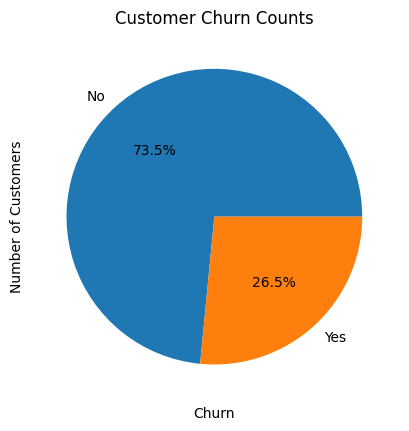

In [6]:
import matplotlib.pyplot as plt

plt.pie(churn_counts['count'], labels=churn_counts['churn'], autopct='%1.1f%%')
plt.title('Customer Churn Counts')  
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()

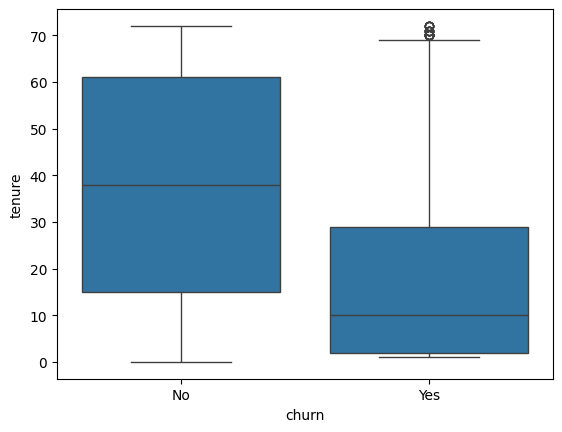

In [9]:
query = """
SELECT tenure, churn
FROM telco_customer
"""
tenure_churn_data = pd.read_sql(query, con=engine)

import seaborn as sns
sns.boxplot(x='churn', y='tenure', data=tenure_churn_data)
plt.show()

In [11]:
# See if there is a pattern in customers who have churned after a long tenure
query = """
SELECT * 
FROM telco_customer
WHERE churn = 'Yes' AND tenure > 70
"""
q = pd.read_sql(query, con=engine)
print(q)

    customerid  gender  seniorcitizen partner dependents  tenure phoneservice  \
0   2834-JRTUA    Male              0      No         No      71          Yes   
1   7317-GGVPB    Male              0     Yes         No      71          Yes   
2   8809-RIHDD    Male              0     Yes        Yes      72          Yes   
3   0917-EZOLA    Male              1     Yes         No      72          Yes   
4   3886-CERTZ  Female              0     Yes         No      72          Yes   
5   6559-ILWKJ    Male              0     Yes         No      71           No   
6   8580-QVLOC  Female              1     Yes        Yes      72          Yes   
7   2889-FPWRM    Male              0     Yes         No      72          Yes   
8   5287-QWLKY    Male              1     Yes        Yes      71          Yes   
9   2530-ENDWQ  Female              0     Yes         No      71          Yes   
10  3259-FDWOY    Male              0     Yes        Yes      71          Yes   
11  6034-ZRYCV  Female      

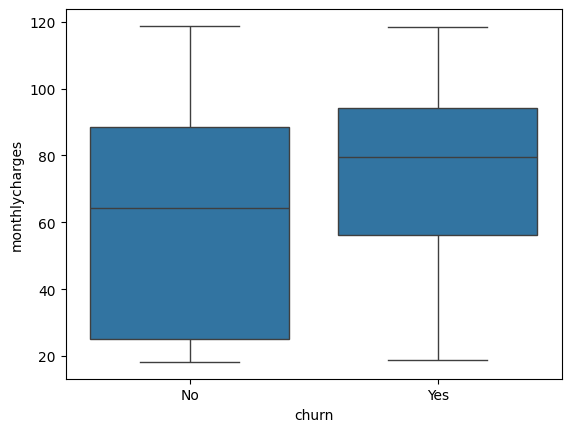

In [59]:
query = """
SELECT monthlycharges, churn
FROM telco_customer
"""
monthly_charges_churn = pd.read_sql(query, con=engine)
sns.boxplot(x='churn', y='monthlycharges', data=monthly_charges_churn)
plt.show()

On average, those who churn have a higher average monthly rate, however from the boxplot, the range of monthly charges has no significant effect on churn so we can not conclude monthly charges effect churn rate. 

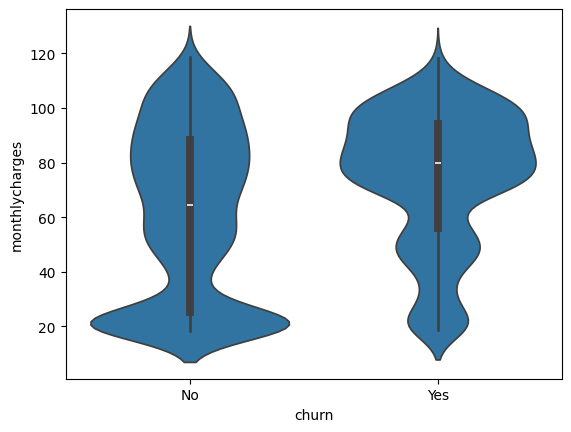

In [60]:
query = """
SELECT monthlycharges, churn
FROM telco_customer
"""
monthly_charges_churn = pd.read_sql(query, con=engine)
sns.violinplot(x='churn', y='monthlycharges', data=monthly_charges_churn)
plt.show()

Churned customers tend to have a higher monthly charge compared the retained customers, with distribution of churned customers shifted towards higher values. Retained customers tend to have a bigger spread. 

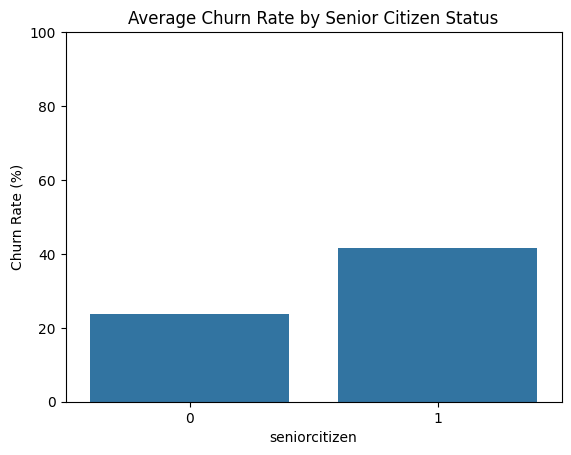

In [57]:
query = """
SELECT seniorcitizen, AVG(CASE WHEN churn = 'Yes' THEN 100 ELSE 0 END) as avg_churn
FROM telco_customer
GROUP BY seniorcitizen
"""
senior_citizen_churn = pd.read_sql(query, con=engine)
sns.barplot(x='seniorcitizen', y='avg_churn', data=senior_citizen_churn)
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)
plt.title('Average Churn Rate by Senior Citizen Status')
plt.show()


Senior citizens have a significantly higher churn rate than non seniors. 

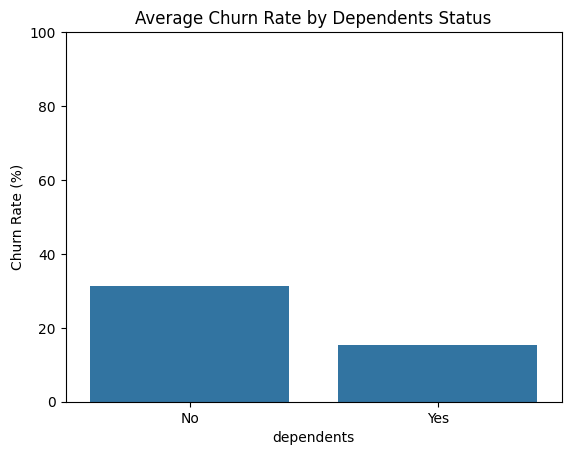

In [56]:
query = """
SELECT dependents, AVG(CASE WHEN churn = 'Yes' THEN 100 ELSE 0 END) as avg_churn
FROM telco_customer
GROUP BY dependents
"""
dependents = pd.read_sql(query, con=engine)
sns.barplot(x='dependents', y='avg_churn', data=dependents)
plt.ylabel('Churn Rate (%)')
plt.ylim(0, 100)
plt.title('Average Churn Rate by Dependents Status')
plt.show()

There is a slight pattern indicating customers with no dependents have a higher churn rate than those with dependents. This could be due to the need for stability, and responsibilities for those with dependents. 

In [ ]:
query = """
SELECT contract, COUNT(*) as count
FROM telco_customer
GROUP BY contract
"""
q = pd.read_sql(query, con=engine)
q

,contract,count
0,One year,1473
1,Month-to-month,3875
2,Two year,1695


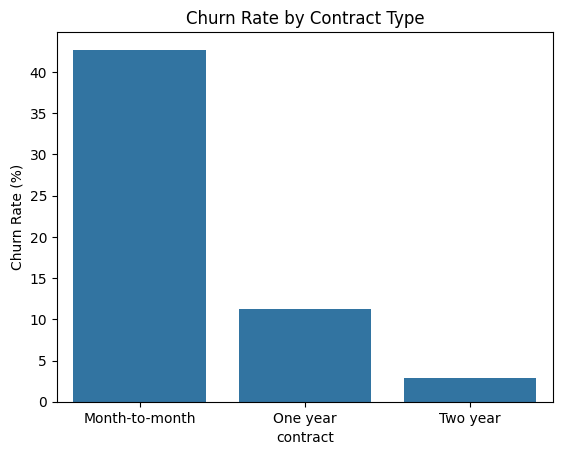

In [51]:
query = """
SELECT contract, AVG(CASE WHEN churn = 'Yes' THEN 100 ELSE 0 END) as churn_rate
FROM telco_customer
GROUP BY contract
ORDER BY contract
"""
tenure_contract = pd.read_sql(query, con=engine)
sns.barplot(x='contract', y='churn_rate', data=tenure_contract)
plt.ylabel('Churn Rate (%)')    
plt.title('Churn Rate by Contract Type')
plt.show()

Customers on Month-to-Month contracts have a much higher churn rate compared to those on longer contrac lengths. This shows that longer contract lengths have a higher retention rate of customers. 

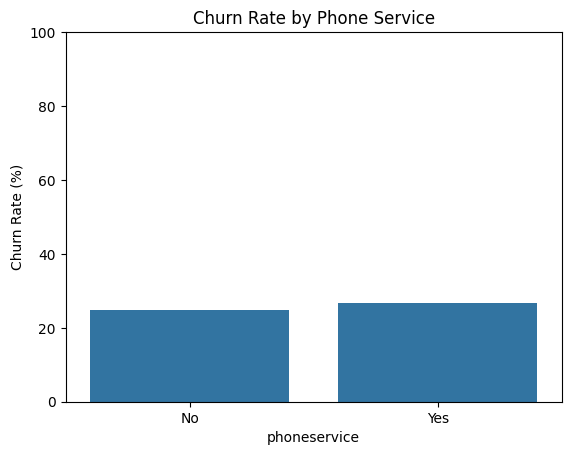

In [55]:
query = """
SELECT phoneservice, AVG(CASE WHEN churn = 'Yes' THEN 100 ELSE 0 END) as churn_rate
FROM telco_customer
GROUP BY phoneservice
"""
q = pd.read_sql(query, con=engine)
sns.barplot(x='phoneservice', y='churn_rate', data=q)
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Phone Service')
plt.ylim(0, 100)
plt.show()

Whether the customer has phone services or not seems to hold no effect on the customers' churn rate. 

Overall, EDA revealed that short contract length, dependents and higher monthly charges are associated with a higher churn rate. These factors should be prioritised for retention strategies as included in the model.

## Modelling

## Evaluation

## Conclusion
